In [3]:
import os 
import keyring

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [4]:
# set states
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [5]:
# set tools (web search, PythonREPL)
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool

web_search = TavilySearchResults(max_results=2)
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your cahrts."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. chart labels should be written in English.
    This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Sucessfully executed: \n ```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    
tools = [web_search, python_repl]
tool_node = ToolNode(tools)

In [6]:
# give tools to LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

def agent(state: State):
    result = llm_with_tools.invoke(state['messages'])
    return {"messages": [result]}

In [7]:
def should_continue(state):
    messages = state['messages']
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [10]:
# build a graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)

workflow.add_node("agent", agent)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "agent")

# we now add a condional edge
workflow.add_conditional_edges(
    "agent",
    
    should_continue,
    
    {
        "continue": "tool",
        # otherwise we finish
        "end":END
    }
)

# we now add a normal edge from 'tools' to 'agent'. 
# this means that after 'tools' is called, 'agent' node is called next.
workflow.add_edge("tool", "agent")

# set up memory
memory = MemorySaver()

graph = workflow.compile(checkpointer=memory, interrupt_before=['tool'])

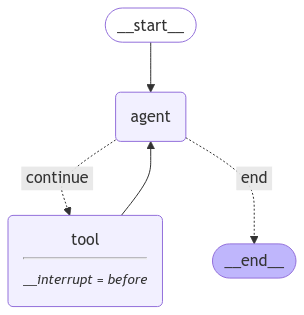

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
initial_input = {"messages": [HumanMessage(content="미국의 최근 5개년(~2023) GDP 차트를 그려줄래?")]}
thread = {"configurable": {"thread_id": "13"}}
async for chunk in graph.astream(initial_input, thread, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'agent'
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6bNktx4quRVttNb4oDXxm8sM', 'function': {'arguments': '{"query":"US GDP data last 5 years 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 170, 'total_tokens': 197, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e7702248-6c05-460a-ae8f-733ccc90708d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US GDP data last 5 years 2023'}, 'id': 'call_6bNktx4quRVttNb4oDXxm8sM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 170, 'output_tokens'

In [13]:
async for chunk in graph.astream(None, thread, stream_mode='updates'):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values)
        print("\n\n")

Receiving update from node: 'tool'
{'messages': [ToolMessage(content='[{"url": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-growth-rate", "content": "U.S. GDP Growth Rate 1961-2024 | MacroTrends U.S. GDP Growth Rate 1961-2024 GDP Growth Rate Annual percentage growth rate of GDP at market prices based on constant local currency. U.S. gdp growth rate for 2023 was 2.54%, a 0.61% increase from 2022. U.S. gdp growth rate for 2022 was 1.94%, a 3.86% decline from 2021. U.S. gdp growth rate for 2021 was 5.80%, a 8.01% increase from 2020. U.S. gdp growth rate for 2020 was -2.21%, a 4.68% decline from 2019. | Country Name | GDP Growth (%) | | U.S. GDP Growth Rate - Historical Data | | U.S. GDP Growth Rate 1961-2024 |  | | U.S. GDP Growth Rate 1961-2024 |  |"}, {"url": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-gross-domestic-product", "content": "| 2023 | $27,360.94B | $81,695 | 2.54% | | 2022 | $25,744.11B | $77,247 | 1.94% | | 202

Python REPL can execute arbitrary code. Use with caution.


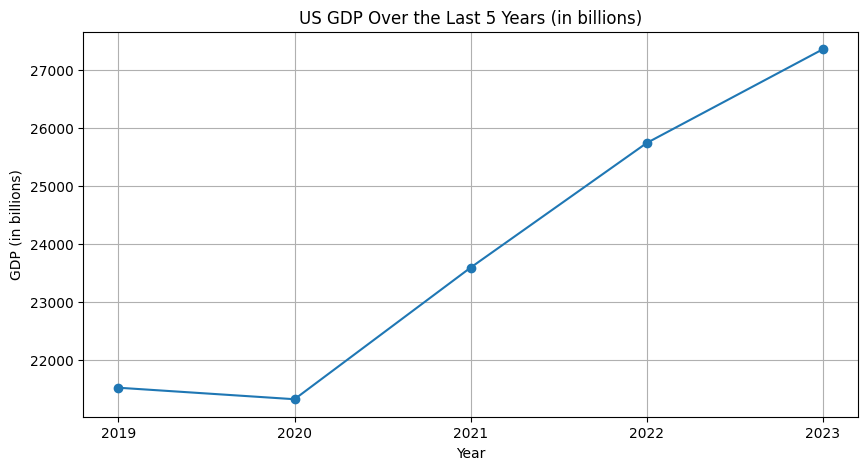

Receiving update from node: tool
{'messages': [ToolMessage(content="Sucessfully executed: \n ```python\nimport matplotlib.pyplot as plt\n\n# Data for US GDP over the last 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\nGDP = [21521.40, 21322.95, 23594.03, 25744.11, 27360.94]  # in billions\n\n# Plotting the data\nplt.figure(figsize=(10, 5))\nplt.plot(years, GDP, marker='o')\nplt.title('US GDP Over the Last 5 Years (in billions)')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billions)')\nplt.xticks(years)\nplt.grid()\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', id='fffd8d23-5fb7-4e97-b475-b9d25fdb7ba7', tool_call_id='call_bAsxxBTIR3jIUGp7G12KGsaN')]}



Receiving update from node: agent
{'messages': [AIMessage(content='Here is the chart showing the US GDP over the last 5 years (in billions):\n\n- **2019**: $21,521.40 billion\n- **2020**: $21,322.95 billion\n- **2021**: $23,594.03 billion\n- **2022**: $25,744.11 billion\n- *

In [14]:
async for chunk in graph.astream(None, thread, stream_mode='updates'):
    for node, values in chunk.items():
        print(f"Receiving update from node: {node}")
        print(values)
        print("\n\n")